## ReadMe
1. Run all the modules 
2. **don't be scared if P1() returns an error, it's normal** (P1 was placed there to minimize the effort of scrolling after changing the parameters)
3. Change the parameters as you wish (intructions how to bellow)
4. Run P1 and analyze the results
5. Repeat steps 3 and 4 how many times you would like to


**Note:
The function EASingleObjective is the one that does all the work regarding the evolution. The function P1 only calls EASingleObjective multiple times, saves and print the results. Some adicional functions are hidden in a py file called auxfunctionsP1SingleObjective. For further inspection open the file and analyze it**

# Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from deap import base, creator, tools

#file generated by us that has the functions created by us 
from auxfunctionsP1SingleObjective import * 

# Read files 

In [2]:
CustDist_WHCentral = pd.read_csv("files/CustDist_WHCentral.csv", sep=",", decimal=".")
del CustDist_WHCentral["Distances between Customers and Warehouse"]
CustDist_WHCentral_list = CustDist_WHCentral.values.tolist()

CustDist_WHCorner = pd.read_csv("files/CustDist_WHCorner.csv", sep=",", decimal=".")
del CustDist_WHCorner["Distances between Customers and Warehouse"]
CustDist_WHCorner_list = CustDist_WHCorner.values.tolist()

CustOrd = pd.read_csv("files/CustOrd.csv", sep=",", decimal=".")
del CustOrd["Customer"]
CustOrd_list = CustOrd.values.tolist()

CustPos_WHCentral = pd.read_csv("files/CustXY_WHCentral.csv", sep=",", decimal=".")
del CustPos_WHCentral["Customer XY"]
CustPos_WHCentral_list = CustPos_WHCentral.values.tolist()

CustPos_WHCorner = pd.read_csv("files/CustXY_WHCorner.csv", sep=",", decimal=".")
del CustPos_WHCorner["Customer XY"]
CustPos_WHCorner_list = CustPos_WHCorner.values.tolist()

In [3]:
# load a configuration file with the parameters of the problem
exec(open("configsP1.py").read())

In [4]:
def P1():

    #selects the file to be used with the costs 
    if(Warehouse_location == "Central"):
        CustDist = CustDist_WHCentral_list
        Coordinates = CustPos_WHCentral_list
    else:
        CustDist = CustDist_WHCorner_list
        Coordinates = CustPos_WHCorner_list
     
    #selects the mode of the costs in deliveries 
    if(deliver_type == "variable"):
        CustOrd = CustOrd_list
    else: 
        CustOrd = None 

        
    #results is a list of (best_ind, mean, std, min)
    results = []
    
    #iterate over a previous defined number of iterations 
    for i in range(n_iterations):
        seed = random.randint(1, 100000) 
        results.append(EASingleObjective(Number_Customers, Population_Size, 
                                         Number_of_Evaluations, seed, CustDist, CustOrd, i+1))

        
    #ajusts the final result
    for i in range(n_iterations):
        for j in range(Number_Customers):
            results[i][0][j] = results[i][0][j] + 1
    
    #initialization
    min_index = 0
    minimum = 9999999
    avg_mean = 0
    avg_std = 0
    avg_min = 0
    
    #interpretate the results
    for i in range(len(results)):
        if(results[i][3] < minimum):
            min_index = 0
        avg_mean = avg_mean + results[i][1]
        avg_std = avg_std + results[i][2]
        avg_min = avg_min + results[i][3]
    
    avg_mean = avg_mean / n_iterations
    avg_std = avg_std / n_iterations
    avg_min = avg_min / n_iterations
    
    print("  At the end of ",n_iterations, " executions")
    print("  Avg Min %s" % avg_min)
    print("  Avg mean %s" % avg_mean)
    print("  Avg Std %s" % avg_std)
    print("  Best individual is %s, %s" % (results[min_index][0], results[min_index][3]))
    
    #gets the route and gives the visual representation 
    final_route = get_route(results[min_index][0] ,CustOrd, Number_Customers)
    plot_best_route_on_grid(final_route, Coordinates, results[min_index][3], Number_Customers)
    
    return 

In [5]:
def EASingleObjective(Number_Customers, Population_Size, Number_of_Evaluations, seed, CustDist, CustOrd_list, iteration):
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    ## permutation setup for individual,
    toolbox.register("indices", \
                     random.sample, \
                     range(Number_Customers), 
                     Number_Customers)

    toolbox.register("individual", \
                     tools.initIterate, \
                     creator.Individual, toolbox.indices)

    ## population setup,
    toolbox.register("population", \
                     tools.initRepeat, \
                     list, toolbox.individual)

    #setup of the methods used in evolution
    toolbox.register("mate", tools.cxOrdered)
    toolbox.register("mutate", invmutTSP)
    toolbox.register("select", tools.selTournament, tournsize=5)
    
    #definition of the evaluation function
    if(CustOrd_list != None):
        toolbox.register("evaluate", evaluatecostvariable)
    else:
        toolbox.register("evaluate", evaluatecostfixed)
        
    
    random.seed(seed)

    # create an initial population of n individuals (where
    # each individual is a list of indexes)
    pop = toolbox.population(n=Population_Size)
    
    if(heuristic == 1):
        heuristic_ind = creator.Individual(generate_heuristic())
        for i in range(len(heuristic_ind)):
            heuristic_ind[i] = heuristic_ind[i] - 1
        print("Heuristic individual inserted in population")

        
    if(verbose == 1):
        print("Start of evolution")
    
    # Evaluate the entire population
    fitnesses = []
    for ind in pop:
        fitnesses.append(toolbox.evaluate(ind, CustDist, CustOrd_list))
    #fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    if(verbose == 1):    
        print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]

    # Variable keeping track of the number of generations
    g = 0
    arr_mean = []
    arr_min = []
    # Begin the evolution
    while g < Number_of_Evaluations/ Population_Size:
        # A new generation
        g = g + 1
        
        if(verbose == 1):
            print("-- Generation %i --" % g)
        
        # Select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < CXPB:
                toolbox.mate(child1, child2)

                # fitness values of the children
                # must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability MUTPB
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
    
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = []
        for ind in invalid_ind:
            fitnesses.append(toolbox.evaluate(ind, CustDist, CustOrd_list))
        #fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        if(verbose == 1):
            print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring
        
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        if(verbose == 1):
            print("  Min %s" % min(fits))
            print("  Max %s" % max(fits))
            print("  Avg %s" % mean)
            print("  Std %s" % std)

        arr_mean.append(mean)
        arr_min.append(min(fits))
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    
    if(verbose == 1):
        print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
    
        x_coordinate = [i+1 for i in range(len(arr_mean))]
        plt.plot(x_coordinate, arr_mean, label = "Average")
        plt.plot(x_coordinate, arr_min, label = "Min")
        plt.title("Min and Average Fitness over generations of iteration %s" % iteration)
        plt.legend()
        plt.grid()
        plt.figure()

    return (best_ind, mean, std, min(fits))

In [6]:
#generates the heuristic element
def generate_heuristic():
    
    #selects the file to be used with the costs 
    if(Warehouse_location == "Central"):
        CustPos = CustPos_WHCentral_list
    else:
        CustPos = CustPos_WHCorner_list
    
    CustPos_list_XG50 = [] #list of customers with X > 50
    CustPos_list_XL50 = [] #list of customers with X < 50
    for customer in CustPos:
        
        if customer == [50,50]:
            pass
        elif customer[0] > 50:
            CustPos_list_XG50.append(customer)
        else:
            CustPos_list_XL50.append(customer)
    

    CustPos_list_XL50.sort(key=lambda x: x[1])

    CustPos_list_XG50.sort(key=lambda x: x[1], reverse=True)
    

    CustPos_list_XL50.extend(CustPos_list_XG50)

    
    
    heuristic_coords = CustPos_list_XL50
   
    heuristic_list = []
    for customer in heuristic_coords:
        heuristic_list.append(CustPos.index(customer))
    

    return heuristic_list

-- End of (successful) evolution --
-- End of (successful) evolution --


/home/lima/.local/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/lima/.local/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


-- End of (successful) evolution --
-- End of (successful) evolution --
-- End of (successful) evolution --
-- End of (successful) evolution --
-- End of (successful) evolution --
-- End of (successful) evolution --
-- End of (successful) evolution --
-- End of (successful) evolution --
  At the end of  10  executions
  Avg Min 369.4
  Avg mean 393.582
  Avg Std 38.81941312702276
  Best individual is [9, 6, 8, 5, 7, 4, 10, 1, 2, 3], 379.0


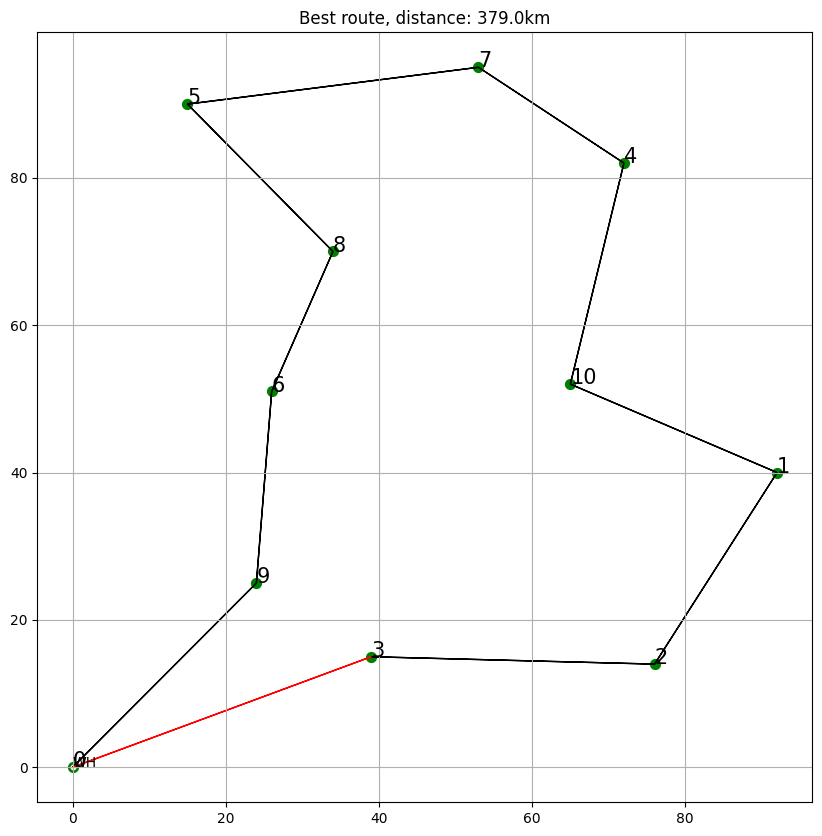

In [7]:
P1()